In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

In [2]:
def load_data(region_str):
    sources = []
    for path in Path('data').rglob(region_str):
        print(path)
        # Get year, lookahead: https://stackoverflow.com/questions/33681372
        year = re.search(r'(\d{4})(?=-)', str(path))[0]
        year = int(year) + 2 # Center year of timeframe, kind of
        temp = pd.read_csv(path)
        temp.columns = map(str.lower, temp.columns)
        temp['year'] = year
        sources.append(temp)
    df = pd.concat(sources)
    return df

def prep_data(df):
    df = df.copy() # Make local copy so not modified inplace
    df = df[df['lntitle'] == 'Total']
    df = pd.pivot_table(
        df,
        index=['geoname', 'geoid'],
        columns=['year'],
        values=['cvap_est']
    )
    df.columns = df.columns.droplevel(0)
    df = df.reset_index(drop=False)

    # How to handle nulls?
    # DC, LaSalle, Petersburg it's a naming thing, others maybe didn't exist?
    # So pull these out and collapse ones with same geoid, and include
    # null values for years of discontinued regions.
    nulls = df[df.isnull().any(axis=1)]
    nulls = nulls.groupby(by='geoid').max() #Collapse
    nulls.reset_index(drop=False, inplace=True)

    # Remove processed nulls from county_df, concat them on.
    df = df[~df['geoid'].isin(nulls['geoid'])]
    df = pd.concat([df, nulls])
    df.set_index(['geoid', 'geoname'], inplace=True)
    return df

def predict(row, years, predict_years):
    # reg = stats.linregress(x=x_values, y=row)
    # y = mx+b
    # results = [reg.slope*i + reg.intercept for i in predict_years]
    # Use statsmodels because it correctly drops missing values
    X = sm.add_constant(years)
    y = row
    model = sm.OLS(y, X, missing='drop').fit()
    results = model.predict(sm.add_constant(predict_years))
    return results

def predict_years(df, predict_years):
    
    df = df.copy() #Local copy

    known_years = [int(x) for x in df.columns]

    df[predict_years] = df.apply(
        predict, years=known_years, predict_years=predict_years,
        axis=1, result_type='expand'
    )
    
    # Tidy data
    df = df.melt(ignore_index=False, value_name='cvap_est')
    df.reset_index(drop=False, inplace=True)
    df = df.round()
    df = df.sort_values(by=['year', 'geoname'], ascending=True)
    
    return df

# Counties

In [3]:
county_df = load_data('County.csv')
county_df

data/CVAP_2008-2012_ACS_csv_files/County.csv
data/CVAP_2009-2013_ACS_csv_files/County.csv
data/CVAP_2005-2009_ACS_csv_files/County.csv
data/CVAP_2010-2014_ACS_csv_files/County.csv
data/CVAP_2011-2015_ACS_csv_files/County.csv
data/CVAP_2014-2018_ACS_csv_files/County.csv
data/CVAP_2013-2017_ACS_csv_files/County.csv
data/CVAP_2012-2016_ACS_csv_files/County.csv
data/CVAP_2015-2019_ACS_csv_files/County.csv
data/CVAP_2007-2011_ACS_csv_files/County.csv
data/CVAP_2006-2010_ACS_csv_files/County.csv


,geoname,lntitle,geoid,lnnumber,tot_est,tot_moe,adu_est,adu_moe,cit_est,cit_moe,cvap_est,cvap_moe,year
0,"Autauga County, Alabama",Total,05000US01001,1,54590,NaN,39955,NaN,54100,191,39580,157,2010
1,"Autauga County, Alabama",Not Hispanic or Latino,05000US01001,2,53280,NaN,39150,NaN,53040,121,38980,93,2010
2,"Autauga County, Alabama",American Indian or Alaska Native Alone,05000US01001,3,160,69.0,155,69.0,160,69,155,69,2010
3,"Autauga County, Alabama",Asian Alone,05000US01001,4,465,135.0,325,76.0,330,110,215,70,2010
4,"Autauga County, Alabama",Black or African American Alone,05000US01001,5,9815,168.0,6940,40.0,9780,168,6940,40,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41868,"Yauco Municipio, Puerto Rico",Asian and White,05000US72153,9,0,123.0,0,123.0,0,123,0,123,2008
41869,"Yauco Municipio, Puerto Rico",Black or African American and White,05000US72153,10,0,123.0,0,123.0,0,123,0,123,2008
41870,"Yauco Municipio, Puerto Rico",American Indian or Alaska Native and Black or ...,05000US72153,11,0,123.0,0,123.0,0,123,0,123,2008
41871,"Yauco Municipio, Puerto Rico",Remainder of Two or More Race Responses,05000US72153,12,0,123.0,0,123.0,0,123,0,123,2008


In [4]:
county_df = prep_data(county_df)
county_df

,year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
geoid,geoname,,,,,,,,,,,
05000US45001,"Abbeville County, South Carolina",19260.0,19355.0,19270.0,19410.0,19400.0,19395.0,19400.0,19505.0,19450.0,19365.0,19420.0
05000US22001,"Acadia Parish, Louisiana",42845.0,44015.0,44230.0,44465.0,44640.0,44775.0,44860.0,45035.0,45195.0,45325.0,45615.0
05000US51001,"Accomack County, Virginia",28050.0,25365.0,25025.0,24860.0,24725.0,24580.0,24570.0,24490.0,24410.0,24340.0,23995.0
05000US16001,"Ada County, Idaho",261160.0,268590.0,274200.0,279745.0,286465.0,292940.0,298835.0,307090.0,316190.0,325745.0,335550.0
05000US19001,"Adair County, Iowa",5845.0,5940.0,5945.0,5900.0,5890.0,5860.0,5780.0,5685.0,5570.0,5500.0,5480.0
...,...,...,...,...,...,...,...,...,...,...,...,...
05000US11001,"District of Columbia, District of Columbia",430110.0,435875.0,444270.0,454205.0,466325.0,475400.0,485115.0,494090.0,503110.0,511190.0,519265.0
05000US22059,"LaSalle Parish, Louisiana",10475.0,11050.0,11080.0,11185.0,11180.0,11220.0,11155.0,11185.0,11130.0,11200.0,11160.0
05000US46102,"Oglala Lakota County, South Dakota",NaN,NaN,NaN,NaN,NaN,NaN,8905.0,8860.0,8940.0,8980.0,8990.0


In [5]:
years = [2004, 2005, 2006, 2018, 2019, 2020, 2021]
county_df = predict_years(county_df, years)
county_df

,geoid,geoname,year,cvap_est
35453,05000US45001,"Abbeville County, South Carolina",2004,19270.0
35454,05000US22001,"Acadia Parish, Louisiana",2004,42939.0
35455,05000US51001,"Accomack County, Virginia",2004,26918.0
35456,05000US16001,"Ada County, Idaho",2004,237421.0
35457,05000US19001,"Adair County, Iowa",2004,6145.0
...,...,...,...,...
58001,05000US04027,"Yuma County, Arizona",2021,136756.0
58002,05000US08125,"Yuma County, Colorado",2021,6884.0
58003,05000US48505,"Zapata County, Texas",2021,6612.0
58004,05000US48507,"Zavala County, Texas",2021,8773.0


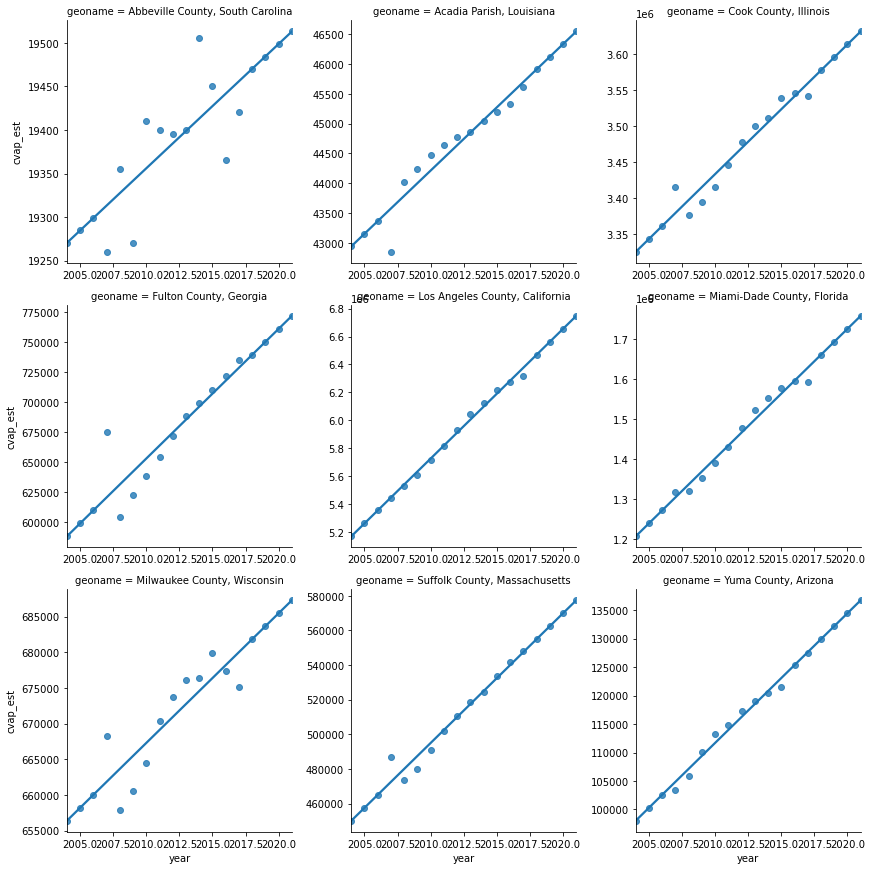

In [6]:
counties = ['Milwaukee County, Wisconsin', 'Cook County, Illinois',
    'Los Angeles County, California', 'Suffolk County, Massachusetts', 'Yuma County, Arizona',
    'Acadia Parish, Louisiana', 'Abbeville County, South Carolina', 'Miami-Dade County, Florida',
    'Fulton County, Georgia']
plt_df = county_df[county_df['geoname'].isin(counties)]

sns.lmplot(x='year', y='cvap_est', col='geoname', data=plt_df, sharey=False, sharex=False,
           col_wrap=3, ci=None, height=4) #, scatter_kws={"s": 50, "alpha": 1}
# Lower population areas are more erratic, but seems to perform well overall.
# The year 2007, which is the first census source (2005-2010), also seems strange.

In [23]:
county_df.to_csv('./data/output/county-cvap-2004-2021.csv', index=False)

# States

In [11]:
state_df = load_data('State.csv')
state_df

data/CVAP_2008-2012_ACS_csv_files/State.csv
data/CVAP_2009-2013_ACS_csv_files/State.csv
data/CVAP_2005-2009_ACS_csv_files/State.csv
data/CVAP_2010-2014_ACS_csv_files/State.csv
data/CVAP_2011-2015_ACS_csv_files/State.csv
data/CVAP_2014-2018_ACS_csv_files/State.csv
data/CVAP_2013-2017_ACS_csv_files/State.csv
data/CVAP_2012-2016_ACS_csv_files/State.csv
data/CVAP_2015-2019_ACS_csv_files/State.csv
data/CVAP_2007-2011_ACS_csv_files/State.csv
data/CVAP_2006-2010_ACS_csv_files/State.csv


,geoname,lntitle,geoid,lnnumber,tot_est,tot_moe,adu_est,adu_moe,cit_est,cit_moe,cvap_est,cvap_moe,year
0,Alabama,Total,04000US01,1,4777325,NaN,3647095,348.0,4661595,2494,3544660,2211,2010
1,Alabama,Not Hispanic or Latino,04000US01,2,4595060,566.0,3531765,544.0,4553725,1768,3495510,1557,2010
2,Alabama,American Indian or Alaska Native Alone,04000US01,3,23760,873.0,17900,604.0,23730,878,17870,605,2010
3,Alabama,Asian Alone,04000US01,4,55045,956.0,41145,640.0,34060,1018,23105,789,2010
4,Alabama,Black or African American Alone,04000US01,5,1250855,1837.0,907645,1129.0,1245335,1873,902495,1223,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,Puerto Rico,Asian and White,04000US72,9,185,114.0,90,59.0,185,114,90,59,2008
672,Puerto Rico,Black or African American and White,04000US72,10,1405,254.0,1050,216.0,1360,254,1005,205,2008
673,Puerto Rico,American Indian or Alaska Native and Black or ...,04000US72,11,0,123.0,0,123.0,0,123,0,123,2008
674,Puerto Rico,Remainder of Two or More Race Responses,04000US72,12,175,107.0,155,99.0,175,107,155,99,2008


In [12]:
state_df = prep_data(state_df)
state_df

,year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
geoid,geoname,,,,,,,,,,,
04000US01,Alabama,3430110,3481375,3514600,3544660,3573935,3600135,3620995,3639495,3651915,3671110,3685075
04000US02,Alaska,479940,483060,493715,503360,511675,519015,523945,527810,530555,530385,530995
04000US04,Arizona,4087550,4110890,4197365,4285735,4363640,4444235,4526595,4613575,4690175,4812765,4920450
04000US05,Arkansas,2067620,2090150,2108930,2126800,2140755,2152345,2164085,2175340,2183895,2195870,2207335
04000US06,California,21942930,22329320,22684535,23072670,23460930,23881290,24280350,24582605,24970110,25232635,25494385
04000US08,Colorado,3364440,3403805,3471375,3541580,3610875,3679120,3750955,3824440,3893360,3979325,4063875
04000US09,Connecticut,2460490,2493095,2510770,2529370,2548580,2564235,2574180,2582885,2599795,2600980,2605410
04000US10,Delaware,623675,638160,646475,655780,664535,674335,681605,689655,697330,704110,710280
04000US11,District of Columbia,430110,435875,444270,454205,466325,475400,485115,494090,503110,511190,519265


In [13]:
years = [2004, 2005, 2006, 2018, 2019, 2020, 2021]
state_df = predict_years(state_df, years)
state_df

,geoid,geoname,year,cvap_est
572,04000US01,Alabama,2004,3387950.0
573,04000US02,Alaska,2004,467404.0
574,04000US04,Arizona,2004,3785248.0
575,04000US05,Arkansas,2004,2039974.0
576,04000US06,California,2004,20898047.0
...,...,...,...,...
931,04000US51,Virginia,2021,6437532.0
932,04000US53,Washington,2021,5521485.0
933,04000US54,West Virginia,2021,1454178.0
934,04000US55,Wisconsin,2021,4463973.0


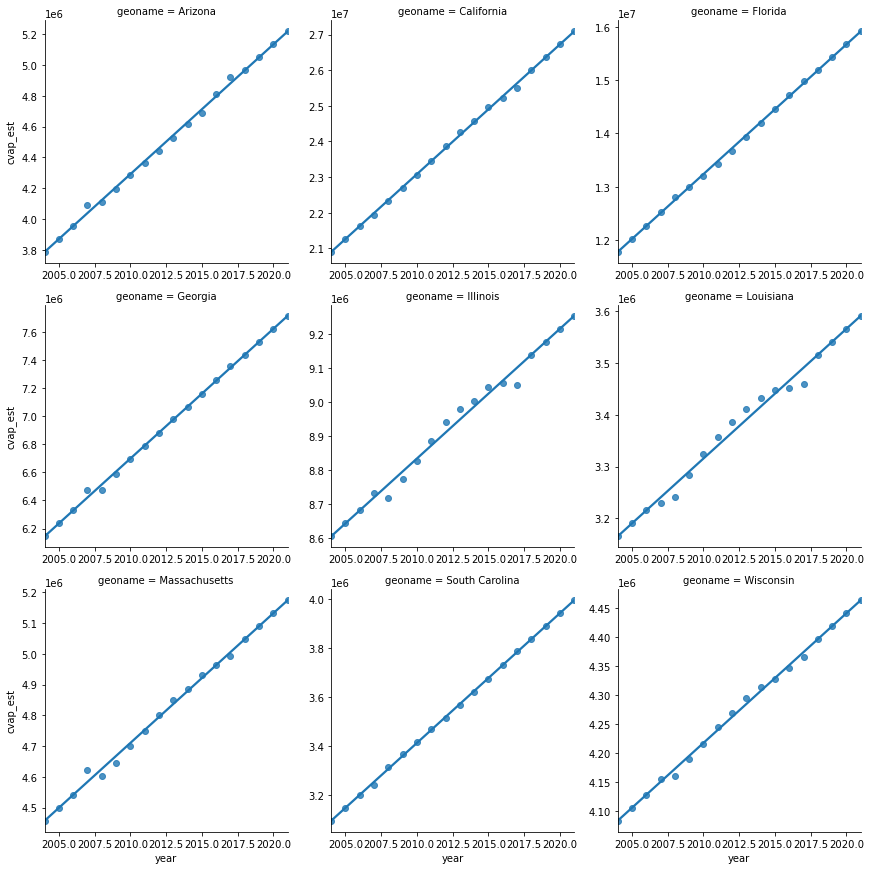

In [14]:
states = ['Wisconsin', 'Illinois',
    'California', 'Massachusetts', 'Arizona',
    'Louisiana', 'South Carolina', 'Florida',
    'Georgia']
plt_df = state_df[state_df['geoname'].isin(states)]
sns.lmplot(x='year', y='cvap_est', col='geoname', data=plt_df, sharey=False, sharex=False,
           col_wrap=3, ci=None, height=4)
# Should work pretty well as long as I don't extrapolate too far out
# E.g. IL, LA may have tapered off in growth.

In [22]:
state_df.to_csv('./data/output/state-cvap-2004-2021.csv', index=False)

# Nation

In [18]:
nation_df = load_data('Nation.csv')
nation_df = prep_data(nation_df)
years = [2004, 2005, 2006, 2018, 2019, 2020, 2021]
nation_df = predict_years(nation_df, years)
nation_df

data/CVAP_2008-2012_ACS_csv_files/Nation.csv
data/CVAP_2009-2013_ACS_csv_files/Nation.csv
data/CVAP_2005-2009_ACS_csv_files/Nation.csv
data/CVAP_2010-2014_ACS_csv_files/Nation.csv
data/CVAP_2011-2015_ACS_csv_files/Nation.csv
data/CVAP_2014-2018_ACS_csv_files/Nation.csv
data/CVAP_2013-2017_ACS_csv_files/Nation.csv
data/CVAP_2012-2016_ACS_csv_files/Nation.csv
data/CVAP_2015-2019_ACS_csv_files/Nation.csv
data/CVAP_2007-2011_ACS_csv_files/Nation.csv
data/CVAP_2006-2010_ACS_csv_files/Nation.csv


,geoid,geoname,year,cvap_est
11,01000US,United States,2004,201239460.0
12,01000US,United States,2005,203558909.0
13,01000US,United States,2006,205878359.0
0,01000US,United States,2007,208196325.0
1,01000US,United States,2008,210235180.0
2,01000US,United States,2009,212664800.0
3,01000US,United States,2010,215144520.0
4,01000US,United States,2011,217576960.0
5,01000US,United States,2012,220055360.0
6,01000US,United States,2013,222464710.0


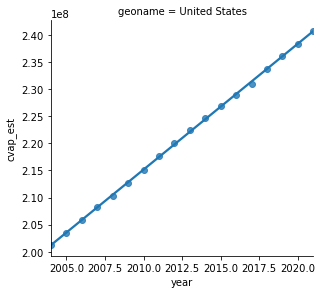

In [19]:
sns.lmplot(x='year', y='cvap_est', col='geoname', data=nation_df, sharey=False, sharex=False,
           col_wrap=3, ci=None, height=4)

In [21]:
nation_df.to_csv('./data/output/nation-cvap-2004-2021', index=False)